# 1D Offshore Spectrum to Nearshore observations

This version of the code used pytorch

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [55]:
#handy function for emptying the chached memory in a GPU
#the kernal should be restarted every time this is run
from numba import cuda
cuda.select_device(0)
cuda.close()

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [2]:
oneD_Off = pd.read_csv('../data/spec1D_offshore.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')

<Axes: >

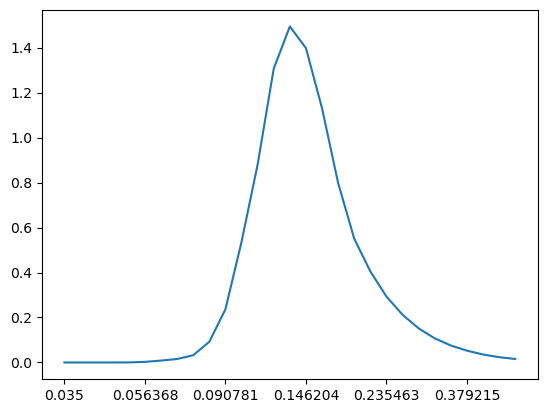

In [3]:
oneD_Off.iloc[0].plot()

We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [4]:
offStats = pd.read_csv("../data/stats_offshore.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')
offStats = offStats.drop(['lat', 'lon'], axis=1)

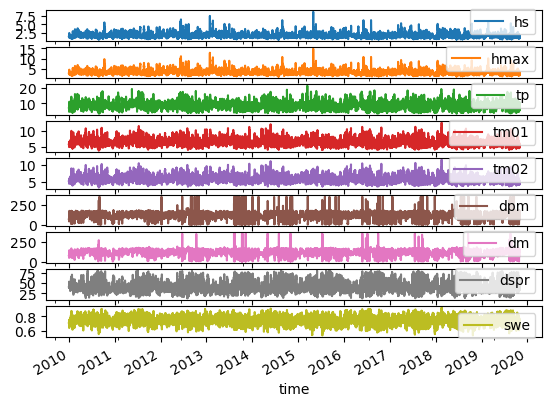

In [5]:
_ = offStats.plot(subplots = True)

## Read in Observational Data

Observational data is available from a number of sources we need to bring them together.

In [6]:
Obs = pd.read_csv('../data/obs_GC.csv', parse_dates = True, index_col = 0)
Obs.columns = ['hs','hmax','tp','tz','dp']

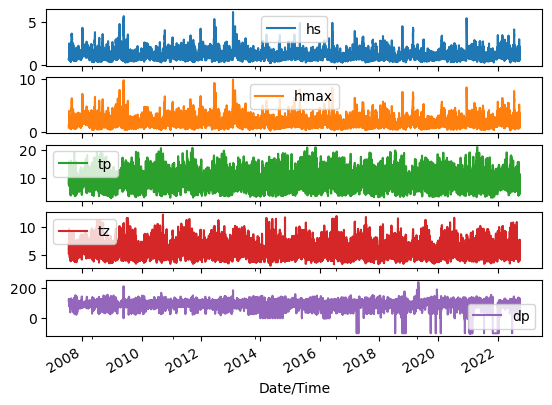

In [7]:
_ = Obs.plot(subplots = True)

In [8]:
new_columns = [column + '_tgt' for column in Obs.columns]
Obs = Obs.rename(columns=dict(zip(Obs.columns, new_columns)))

In [9]:
merged_df = pd.merge(oneD_Off, offStats, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, Obs, left_index=True, right_index=True)

<Axes: >

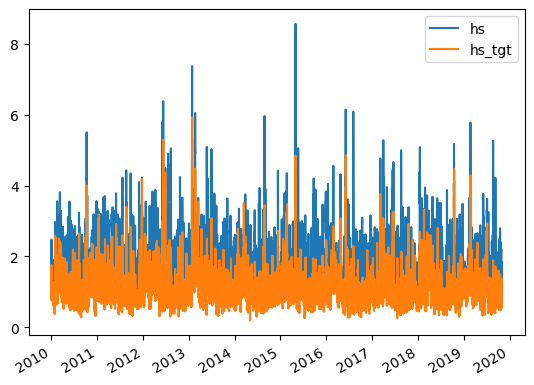

In [10]:
merged_df[['hs','hs_tgt']].plot()

## Feature Engineering

**Time Based**

In [11]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [12]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [13]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [14]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt',
       'tp_tgt', 'tz_tgt', 'dp_tgt', 'year', 'month', 'day', 'day_of_week',
       'hour', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [15]:
dp_col = list(merged_df.columns[merged_df.columns.str.contains('Dir_Tp TRUE_tgt')])
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])

In [16]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col + dp_col)

In [17]:
merged_df['hs+3'] = merged_df['hs'].shift(3)
merged_df['hs+6'] = merged_df['hs'].shift(6)
merged_df['hs+12'] = merged_df['hs'].shift(12)
merged_df['hs+24'] = merged_df['hs'].shift(24)

In [18]:
merged_df.dropna(inplace = True)

In [19]:
merged_df = merged_df.iloc[::3, :] #make 2 hourly

## Keep some independent data

In [20]:
ind_data = merged_df["2019-01-01":]
merged_df  = merged_df[:"2019-01-01"]

## Selecting Training Data

In [21]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt', 'tp_tgt',
       'tz_tgt', 'dp_tgt', 'year', 'month', 'day', 'day_of_week', 'hour',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'dpm_sin', 'dpm_cos', 'dm_sin', 'dm_cos',
       'hs+3', 'hs+6', 'hs+12', 'hs+24'],
      dtype='object')

In [22]:
features_col = ['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735','hs','dm_sin', 'dm_cos',
       'month', 'day', 'hour']

In [23]:
labels_col = ['hs_tgt']

In [24]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [26]:
from sklearn.model_selection import TimeSeriesSplit

In [27]:
T = 12                    #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 12 × 35 × 17357


In [28]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [29]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [30]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [31]:
import torch
import torch.nn as nn

In [32]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [33]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [34]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [35]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(35, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [36]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 25 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [37]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

At epoch 25 of 300, Train Loss: 0.102, Test Loss: 0.106
current test best = 1.000, current test loss is: 0.106
At epoch 25 of 300, Train Loss: 0.102, Test Loss: 0.106
At epoch 50 of 300, Train Loss: 0.046, Test Loss: 0.052
current test best = 0.106, current test loss is: 0.052
At epoch 50 of 300, Train Loss: 0.046, Test Loss: 0.052
At epoch 75 of 300, Train Loss: 0.034, Test Loss: 0.040
current test best = 0.052, current test loss is: 0.040
At epoch 75 of 300, Train Loss: 0.034, Test Loss: 0.040
At epoch 100 of 300, Train Loss: 0.033, Test Loss: 0.051


Find the best model from the training and load that in over the top of the latest one!

In [38]:
resume(model, "best_model.pth")

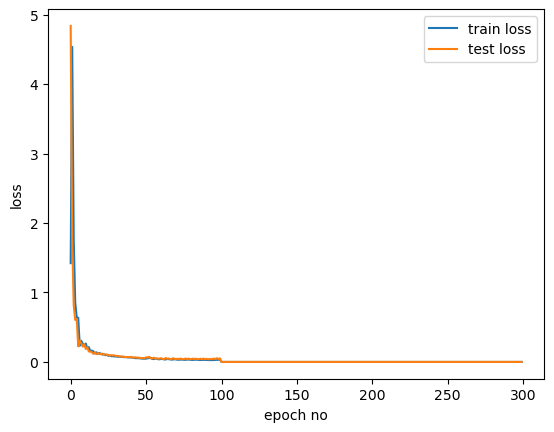

In [39]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()
     

## Assess performance against test data

In [40]:

#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)
  

In [41]:

plot_len = len(test_predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.head(5)

,hs_tgt,prediction
2017-03-19 05:00:00,1.64,1.325971
2017-03-19 09:00:00,1.71,1.302570
2017-03-19 14:00:00,1.50,1.374253
2017-03-19 18:00:00,1.57,1.423879
2017-03-19 23:00:00,1.70,1.451854


Text(0, 0.5, 'Hs (m)')

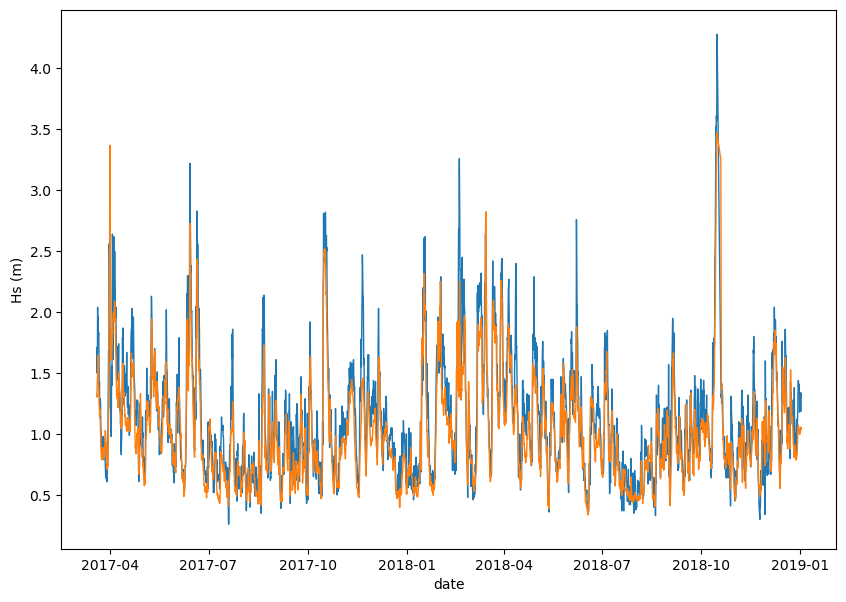

In [42]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


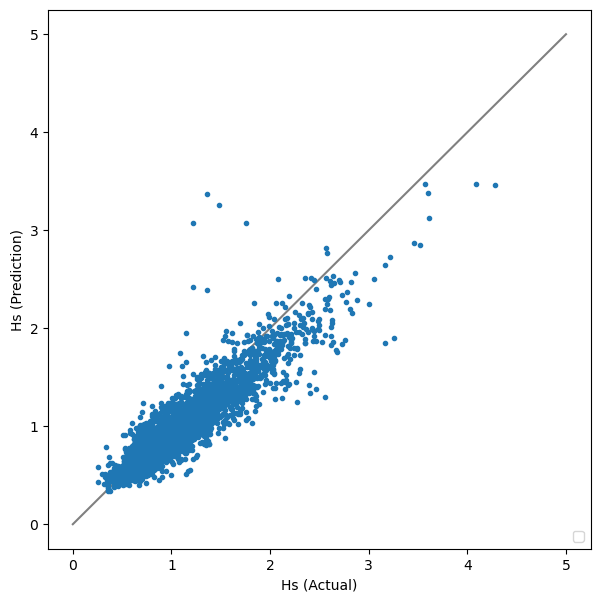

In [43]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in a short-period of time or picking out the extremes.

In [44]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

Mean square error is: 0.051


Text(0.5, 1.0, 'Distribution of Differences')

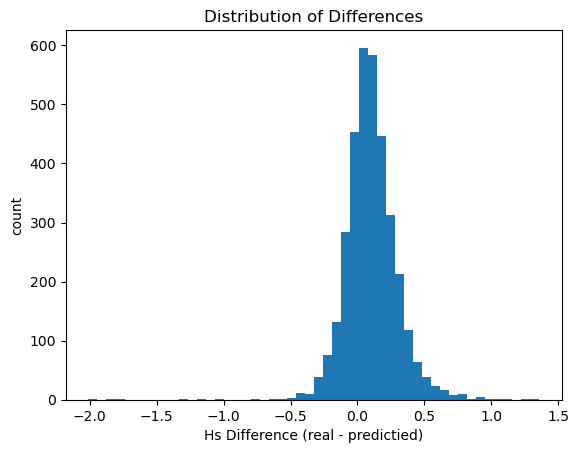

In [45]:
plt.hist(LTSM_error['error'], bins=50)
plt.xlabel('Hs Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

## Test against independent data

In [46]:
features_ind = scaler.transform(ind_data[features_col].values)

In [47]:
len(ind_data)

1600

In [48]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = int(len(ind_data) * 0.9)

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))
y_ind = np.zeros((N - ind_size, 1))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]
  y_ind[i] = (ind_data[labels_col].values[t+T])

In [49]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))
y_ind = torch.from_numpy(y_ind.astype(np.float32))

X_ind, y_ind = X_ind.to(device), y_ind.to(device)

In [50]:
X_ind[i].shape

torch.Size([12, 35])

In [51]:
input_.shape

torch.Size([1, 12, 35])

In [52]:
ind_predictions = []
for i in range(len(y_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  ind_predictions.append(p)

In [53]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = ind_predictions
plot_df.head(5)

,hs_tgt,prediction
2019-10-05 09:00:00,0.56,0.582616
2019-10-05 14:00:00,1.43,0.635108
2019-10-05 18:00:00,1.16,0.677026
2019-10-05 23:00:00,0.56,0.675499
2019-10-06 03:00:00,0.61,0.673355


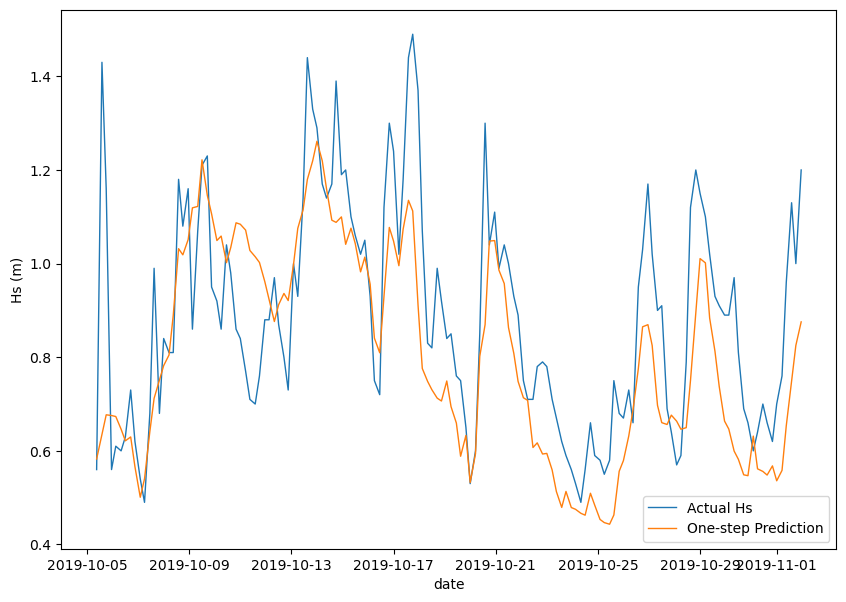

In [54]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')
plt.legend(loc='lower right')